# This notebook will explain how to prepare different data sources for use with Lompe

This is how the data was prepared for the polar cap arc event on 15 December 2014 (notebook 06 in */Lompe_paper_figures/*). 

We start by loading relevant modules:

In [6]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from apexpy import Apex
import lompe
from lompe.model.cmodel import Cmodel
from lompe.data_tools import dataloader

We then select the event date and time we want to make Lompe data for. We specify the *'tempfile_path'* (location of processed data sets) and the *'basepath'* (loaction of 'raw' data files - the unprocessed data).

In [3]:
# set time interval
event = '2014-12-15'
hour = 1
minute = 19
t0 = dt.datetime(int(event[0:4]), int(event[5:7]), int(event[8:10]), hour, minute)
DT = dt.timedelta(seconds = 2 * 60) # will select data from time +/- DT

# apex object for magnetic coordinates
a = Apex(t0.year)

# locations of data
tempfile_path = './sample_dataset/' # to put the processed data
basepath = tempfile_path + 'raw/' # unprocessed downloads

Note that if the already processed file for the event date exists in *'tempfile_path'* it will be used and the files from *'basepath'* are unused.

Then the cubed sphere grid is set up in the region we want to make a Lompe model. The region of interest should have a fairly even distribution of observations, and the grid resolution should be adjusted to fir the resolution of the observations (input data) (see Section 3.1 in the Lompe paper).

In [4]:
position = (-98,73) # lon, lat
orientation = -36 # east, north
L, W = 2500e3, 2500e3 # dimensions of grid (L is along orientation vector)
Lres, Wres = 70.e3, 70.e3 # resolution of grid (Lres is along orientation vector)
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R = 6481.2e3)

You can plot the grid if you want to. This is a grid over a small region in North America:

(-0.20243276025700024, 0.20148907681679254)

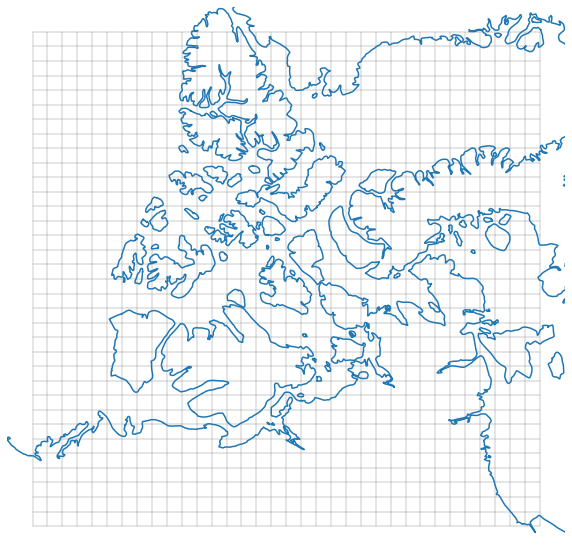

In [4]:
# plot grid and coastlines
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

### Input data 
##### DMSP SSUSI 

First, we look at how images of the aurora can be used with Lompe. The following example will use the SSUSI image for the Polar Cap event (notebook 06) shown in the Lompe paper in Figure 10. The SSUSI data to be used with these scripts can be downloaded from the [SSUSI homepage](https://ssusi.jhuapl.edu/) under the EDR_Aurora data product. The downloaded data is stored in netcdf files for each orbit. They should be stored in *'basepath'*. When constructing the functions returning Hall and Pedersen conductances inside the Lompe grid using the *lompe.model.cmodel.Cmodel()* class as done in the notebook '06_polar_cap_event', a helper function contained in *lompe.data_tools.dataloader.read_ssusi()* is used to read the downloaded data and put it into an xarray format. This processed file is saved in *'tempfile_path'*. When using *Cmodel*, SSUSI images are used as input data for auroral conductances. Further details on preparing the SSUSI based conductance functions are found in the *Cmodel()* class and *dataloader.read_ssusi()* function. Solar conductances are also included in the *Cmodel()* conductance model object (EUV = True).

The conductance model object can be constructed on the model grid:

In [7]:
cmod = Cmodel(grid, event, t0, spline_smoothing = 10, EUV = True, filtersize = 2, how = 'median', 
              param = 'lbhs', sat = 'F18', tempfile_path = tempfile_path, basepath = basepath)

##### DMSP SSIES

Next, we show how ion drift meter data from the DMSP SSIES instrument can be obtained from the  [Madrigal database](http://cedar.openmadrigal.org/) and put into the Lompe format, again using tools in *lompe.data_tools.dataloader*.

*lompe.data_tools.dataloader.read_ssies()* fetches SSIES data using the MadrigalWeb module ([download module here](http://cedar.openmadrigal.org/madrigalDownload) or use [pip install](https://pypi.org/project/madrigalWeb/)). User information has to be provided, but user does not have to sign up anywhere beforehand. Specify which DMSP satellite you want data from (e.g. F16, F17, F18, or F19). *'basepath'* is used for temporary storage of downloaded files. The processed file will be saved in *'tempfile_path'*. If a processed file from the event date already exists in *'tempfile_path'* it will be used. *read_ssies()* will return the path to the processed file for the event date.

In [6]:
# specify
username = 'First Last'
email = 'name@host.com'
aff = 'University'

sat = 17 # DMSP satellite number

madrigal_kwargs = {'user_fullname' : username, 'user_email' : email, 'user_affiliation' : aff}
ssies = pd.read_hdf(dataloader.read_ssies(event, sat, basepath, tempfile_path, **madrigal_kwargs))

The *read_ssies()* function will fecth data for the entire event date. We select data from time interval of interest. The data far away from the model grid will be automatically excluded in Lompe. Then we make the Lompe data object.

In [7]:
# select the time interval of interest
ssies = ssies[t0 - 2*DT : t0 + 2*DT]

# make the Lompe data object
v_crosstrack = np.abs(ssies.hor_ion_v).values
coords = np.vstack((ssies.glon.values, ssies.gdlat.values))
los  = np.vstack((ssies['le'].values, ssies['ln'].values))
# lompe.Data is the Lompe data format
ssies_data = lompe.Data(np.abs(ssies.hor_ion_v).values, coords, datatype = 'convection', scale = 500, LOS = los)

##### SuperDARN
Due to its spatial coverage, a central data source to use with Lompe is SuperDARN convection measurements. Here, we show how the gridded data product produced with RST can be put into the Lompe inversion. This data product consists of merged data from all available radars in each hemisphere that has been spatially and temporally gridded. Such files can either be fetched from [Globus](https://www.globus.org/) after an invitation to join the 'SuperDARN mirror'. To get access, look here for a recipe: https://github.com/SuperDARNCanada/globus

Another source of such gridded data is the gridded published dataset by E.Thomas: https://doi.org/10.5281/zenodo.3618607 (2010-2016).

The gridmap file should be saved in *'basepath'*. The dataloader functions will read from there and save the processed data in *'tempfile_path'*. If a processed file from the event date already exists in *'tempfile_path'* it will be used. *read_sdarn()* will return the path to the processed file for the event date. data from the entire event date will be saved in the processed file, and we need to select data for the time interval of interest before creating the Lompe data object.

In [8]:
# read the superdarn gridmap file into a pandas dataframe
superdarn = pd.read_hdf(dataloader.read_sdarn(event, basepath, tempfile_path))

# select the time interval of interest (also remove very high speeds)
sd = superdarn.loc[(superdarn.index >= t0 - DT) & (superdarn.index <= t0 + DT) & (superdarn.vlos < 2000)].dropna()

# make the Lompe data object
vlos = sd['vlos'].values
coords = np.vstack((sd['glon'].values, sd['glat'].values))
los  = np.vstack((sd['le'].values, sd['ln'].values))
# lompe.Data is the Lompe data format
sd_data = lompe.Data(vlos, coordinates = coords, LOS = los, datatype = 'convection', scale = 500 ) 

Note: Lompe data objects of the *'convection'* data type need the line-of-sight (LOS) parameter.

##### SuperMAG
Next is SuperMAG ground magnetometer data. The following function will read a netcdf file of all stations on the given day, downloaded from the [SuperMAG webpage](https://supermag.jhuapl.edu/). These files should be located in *'basepath'*. Note that the manual SuperMAG download has the download date as default filename, and if a local file is to be used the name of the file must be specified. 

In [9]:
file_name = '20220201-09-33-supermag.netcdf'
supermag = pd.read_hdf(dataloader.read_smag(event, basepath, tempfile_path, file_name))

*OPTION TO USE API*: There is also an option to use the implemented API in *dataloader.read_smag()* which fetches the data directly from the SuperMAG webpage. You will need a SuperMAG user-ID to use the API. If you don't have an ID follow: https://supermag.jhuapl.edu/ -> click *download data* and register for an account. Run the follwing cell to get processed data through the API:

In [ ]:
# specify:
userid = 'id'
# get data
supermag = pd.read_hdf(dataloader.read_smag(event, basepath, tempfile_path, fromfile = False, userid = userid))

Like the other read-functions, *read_smag()* creates a processed file for all available stations on the entire event date. You can remove stations with a latitude cutoff if you want to, however, data far from the model grid will automatically be removed in Lompe anyways. We must select the time interval of interest before we make the Lompe data object:

In [10]:
# latitude cutoff of magnetometers
supermag = supermag[supermag.lat <= 90]
# select the time interval of interest
sm = supermag[t0 - DT : t0 + DT].dropna()

# make the Lompe data object
B = np.vstack((sm.Be.values, sm.Bn.values, sm.Bu.values))
coords = np.vstack((sm.lon.values, sm.lat.values))
# lompe.Data is the Lompe data format
sm_data = lompe.Data(B * 1e-9, coords, datatype = 'ground_mag', scale = 100e-9)

The Lompe Data objects of the 'ground_mag' data type do not have line-of-sight (LOS) parameters. The magnetic field measurements (here called *B*) has the (east, north, up) components integrated.

##### Iridium 

Data handling of *Iridium* space magnetometer data (provided by [AMPERE](http://ampere.jhuapl.edu/)) is also possible by using *dataloader.read_iridium()*. The raw data for the event date - AMPERE dB (Raw Vectors) - with a 2 minute time step  be downloaded from [this page](http://ampere.jhuapl.edu/dataraw/index.html) and should be saved in *'basepath'*. *read_iridium()* will save the processed file in *'tempfile_path'* and return the loaction of the file. As for the other data sets, we must select the time interval of interest before we make the Lompe data object.

Unfortunately, space magnetometer data from AMPERE is not available for the 15 December 2014 event. For the sake of making the data loading example complete, we will use an example event time 5 April 2012 which is a date where we have data. This data will naturally not be included in the 15 December 2014 model.

In [11]:
example_event = '2012-04-05'
# get the processed data set
iridium = pd.read_hdf(dataloader.read_iridium(example_event, basepath, tempfile_path))

# select the time interval of interest
irid = iridium[(iridium.time >= t0) & (iridium.time <= t0 + DT)]

# make the Lompe data object
irid_B = np.vstack((irid.B_e.values, irid.B_n.values, irid.B_r.values))
irid_coords = np.vstack((irid.lon.values, irid.lat.values, irid.r.values))
# lompe.Data is the Lompe data format
iridium_data = lompe.Data(irid_B * 1e-9, irid_coords, datatype = 'space_mag_fac', scale = 200e-9)

##### Data type for Lompe
When making the Lompe data objects, the 'datatype' parameter must be specified. The options are:

- **'ground_mag'**: Magnetic field perturbations on ground (given in Tesla). This is what was used for the SuperMAG observations.

- **'space_mag_full'**: Magnetic field perturbations in space associated with field-aligned currents **and** horizontal divergence-free currents below the satellite (in Tesla). Typically used for low-flying precise magnetometers (e.g. Swarm and CHAMP).

- **'space_mag_fac'**: Magnetic field perturbations in space associated with field-aligned currents (in Tesla). Magnetic field in space that corresponds to only the field-aligned currents. For example, Iridium magnetic data is dominated by FACs, since it is taken at around 800 km altitude, and by magnetometers that do not have the precision of science-mission instruments.

- **'convection'**: Ionospheric convection velocity perpendicular to the magnetic field, mapped to the ionospheric radius (in meters per second). The line-of-sight direction must be specified using the LOS keyword (that should contain the eastward and northward components of the line-of-sight vector). This is the data type for both the ground-based SuperDARN observations and the space-based observations from DMSP SSIES. 

- **'Efield'**: Ionospheric convection electric field, perpendicular to B and mapped to the ionospheric radius (in Volts per meter). The LOS keyword can be used for this parameter also, if only one component of the electric field is known. 

- **'fac'**: Field-aligned electric current density (in Ampere per meter$^2$). This parameter is only meant to be used with large-scale datasets or simulation output that can be interpolated to the Lompe model grid. This is different from all the other datatypes used in Lompe.

##### 'scale' parameter for the Lompe data object
The scale keyword determines a weight for the dataset. It should be set to a typical order of magnitude for the measurement. For example, magnetometer data have typical magnitude $10^{-7}$ T, and plasma flow data typically $100$ m/s. The scale parameter determines the relative importance of the dataset in the model-data misfit minimization. Increasing it will reduce importance of the data set. If you only have one dataset, the scale parameter should be irrelevant. The scale parameter is described in Section 3.3 in the Lompe paper ($\sigma_B$, $\sigma_E$ etc.)

### Final electric field model
Now the data can be added to Lompe and the inversion can be performed. Note that the Lompe electric field model is given Hall and Pedersen conductances from the conductance model when initialized.

In [12]:
# initialize Lompe
model = lompe.Emodel(grid, (cmod.hall, cmod.pedersen))

# add data
model.add_data(sd_data, ssies_data, sm_data)

# run inversion
model.run_inversion(l1 = 1, l2 = 10);
# l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction

Note that multiple Lompe Data objects of the same data type can be passed to the Lompe model once it's initialized.

You can use *lompeplot* to get a summary figure with the model output. When 'include_data = True', the location of input data is shown as orange arrows. This is a similar figure to the one created in notebook 06 with slightly different data input (no DMSP F18 input and including SuperMAG observations).

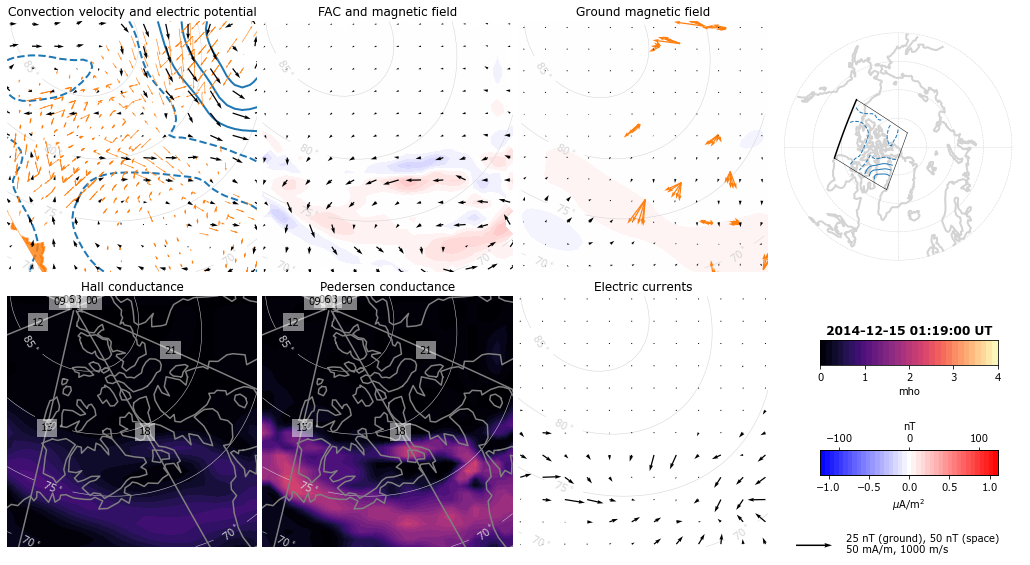

In [13]:
fig = lompe.lompeplot(model, include_data = True, time = t0, apex = a, 
                      colorscales = {'fac'        : np.linspace(-0.55, 0.55, 40) * 1e-6 * 2,
                                     'ground_mag' : np.linspace(-380, 380, 50) * 1e-9 / 3, # upward component
                                     'hall'       : np.linspace(0, 4, 32), # mho
                                     'pedersen'   : np.linspace(0, 4, 32)}, # mho
                      quiverscales={'ground_mag'      : 50*1e-9, 
                                    'space_mag_fac'   : 100*1e-9, 
                                    'space_mag_full'  : 100*1e-9, 
                                    'electric_current': 100 * 1e-3})

The top row shows, from left to right (input data is shown in orange): 
- Convection flow field and electric potential contours
- horizontal magnetic field disturbances 110 km above the ionosphere as black arrows and radial current density as color contours
- horizontal ground magnetic field perturbations as black arrows and radial magnetic field perturbations as color contours
- a map that shows the grid’s position and orientation with respect to apex magnetic latitude and local time.

The bottom row shows, from left to right: 
- Pedersen conductance
- Hall conductance
- horizontal height-integrated ionospheric currents based on Lompe output
- color scale / vector scales